Define functional categories and filter calls for those in Control and SCZ individuals

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy
import re
import attila_utils
import funcvar
import functools
import ensembl_rest
import os.path
from bsmcalls import SNPnexus
from bsmcalls import operations
from bsmcalls import resources
from bsmcalls import individuals
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

## Preparations

Load data: annotated calls

In [2]:
data = SNPnexus.load_data('../../results/2020-09-07-annotations/annotated-calls.p')

### GWAS genes

Here we take supplementary table 4 from the [CLOZUK paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5918692/) (clozapine UK), whose `Gene(s) tagged` column we turn into the `gwasgenes` set.

In [3]:
clozukpath = '../../resources/CLOZUK/supp-table-4.csv'
gwasgenes = operations.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')
print(len(gwasgenes), 'SCZ GWAS genes')

478 SCZ GWAS genes


### Brain expressed genes

#### RoadMap Epigenomics
`BRN.HIPP.MID` is the hippocampus of an adult whereas `BRN.FET.F` the brain of a female fetus (see [the RoadMap metadata](https://docs.google.com/spreadsheets/d/1yikGx4MsO9Ei36b64yOy9Vb6oPC5IBGlFbYEt-N6gOM/edit?usp=sharing)).

In [4]:
rna_roadmap = resources.read_roadmap_rna(sampledict={'E071': 'BRN.HIPP.MID', 'E082': 'BRN.FET.F'})
rna_roadmap

,BRN.HIPP.MID,BRN.FET.F
ENSG00000000003,35.083,53.039
ENSG00000000005,0.251,0.566
ENSG00000000419,26.467,29.927
ENSG00000000457,5.325,8.497
ENSG00000000460,1.487,3.408
...,...,...
ENSG00000259718,0.112,0.000
ENSG00000259741,38.850,45.583
ENSG00000259752,0.048,0.265
ENSG00000259765,0.000,0.000


The distribution of read counts is extremely skewed to the right, which makes it hard to assess correlation

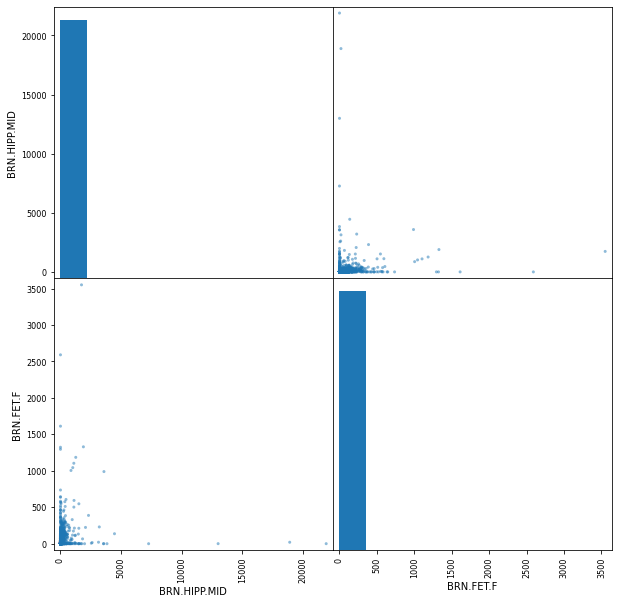

In [5]:
ax = pd.plotting.scatter_matrix(rna_roadmap, figsize=(10, 10))

The log readcount distribution is visually more informative.  There is a clear correlation between `BRN.HIPP.MID` and `BRN.FET.F`.

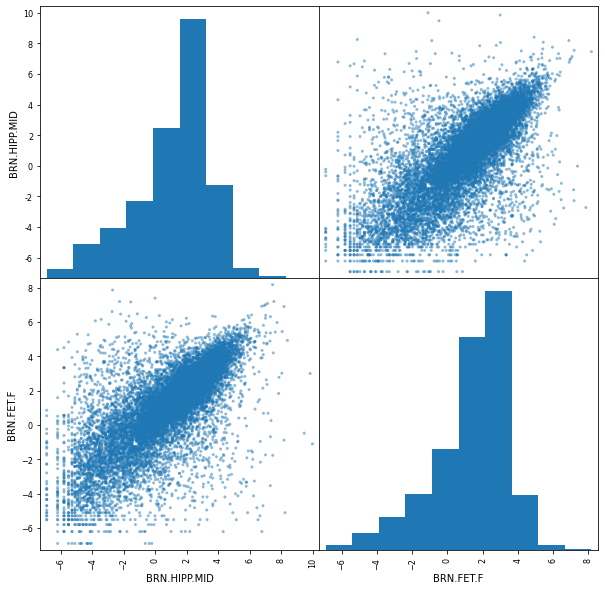

In [6]:
log_rna_roadmap = rna_roadmap.loc[~(rna_roadmap == 0).sum(axis=1).astype('bool')].apply(np.log)
rna = log_rna_roadmap
ax = pd.plotting.scatter_matrix(rna, figsize=(10, 10))

#### Protein Atlas
The [Human Protein Atlas](https://www.proteinatlas.org/humanproteome/brain/human+brain) contains several gene sets based on expression in the brain
1. `brain enriched`
1. `brain elevated`

In [7]:
pa_enriched = resources.read_proteinatlas_rna_brain('enriched')
pa_elevated = resources.read_proteinatlas_rna_brain('elevated')
print(len(pa_enriched), 'genes in the brain enriched set')
print(len(pa_elevated), 'genes in the brain elevated set')
pa_elevated

488 genes in the brain enriched set
2587 genes in the brain elevated set


,Gene,Gene synonym,Gene all names
Ensembl,,,
ENSG00000149452,SLC22A8,{OAT3},"{OAT3, SLC22A8}"
ENSG00000138136,LBX1,"{LBX1H, HPX6}","{LBX1H, HPX6, LBX1}"
ENSG00000131095,GFAP,{FLJ45472},"{GFAP, FLJ45472}"
ENSG00000164438,TLX3,"{RNX, HOX11L2}","{RNX, TLX3, HOX11L2}"
ENSG00000171532,NEUROD2,"{NDRF, bHLHa1}","{NDRF, bHLHa1, NEUROD2}"
...,...,...,...
ENSG00000172000,ZNF556,{FLJ11637},"{FLJ11637, ZNF556}"
ENSG00000173041,ZNF680,{FLJ90430},"{FLJ90430, ZNF680}"
ENSG00000182141,ZNF708,"{ZNF15L1, KOX8, ZNF15}","{ZNF15L1, KOX8, ZNF708, ZNF15}"


The following operations show that 123 genes in the `brain elevated` set of the Human Protein Atlas

In [8]:
print('protein_atlas_elevated AND NOT roadmap:', len(set(pa_elevated.index).difference(set(rna_roadmap.index))))
print('roadmap AND NOT protein_atlas_elevated:', len(set(rna_roadmap.index).difference(set(pa_elevated.index))))

protein_atlas_elevated AND NOT roadmap: 123
roadmap AND NOT protein_atlas_elevated: 17331


On the other hand, the `brain enriched` set (also from the Human Protein Atlas) is a proper subset of the `brain elevated` set.

In [9]:
set(pa_enriched.index).difference(set(pa_elevated.index))

set()

In [10]:
print('protein_atlas_elevated AND NOT log roadmap:', len(set(pa_elevated.index).difference(set(log_rna_roadmap.index))))
print('log roadmap AND NOT protein_atlas_elevated:', len(set(log_rna_roadmap.index).difference(set(pa_elevated.index))))

protein_atlas_elevated AND NOT log roadmap: 296
log roadmap AND NOT protein_atlas_elevated: 15736


#### Discrepancy between Protein Atlas and RoadMap
It is reasonable to expect the `brain enriched` and `brain elevated` gene sets from the Protein Atlas to exhibit an increased expression in the `BRN.HIPP.MID` and `BRN.FET.F` RNA seq data.  However, it isn't so as the bit of analysis below shows.

In [11]:
pa_enriched1 = pa_enriched.drop(set(pa_enriched.index).difference(set(log_rna_roadmap.index)))
log_rna_roadmap['brain enriched'] = False
log_rna_roadmap.loc[pa_enriched1.index, 'brain enriched'] = True
# Now the same for the brain elevated set
pa_elevated1 = pa_elevated.drop(set(pa_elevated.index).difference(set(log_rna_roadmap.index)))
log_rna_roadmap['brain elevated'] = False
log_rna_roadmap.loc[pa_elevated1.index, 'brain elevated'] = True
rna['gene set'] = 'other genes'
rna.loc[rna['brain elevated'], 'gene set'] = 'brain elevated'
rna.loc[rna['brain enriched'], 'gene set'] = 'brain enriched'
categories = ['brain enriched', 'brain elevated', 'other genes']
rna['gene set'] = pd.Categorical(rna['gene set'], categories=categories)
categories.reverse()

['named-figure/brain-elevated-vs-other-genes-log-RPKM.png',
 'named-figure/brain-elevated-vs-other-genes-log-RPKM.pdf']

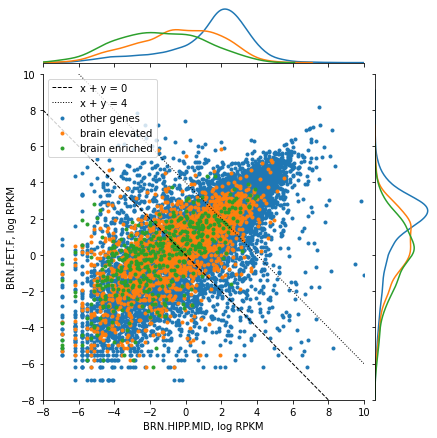

In [12]:
g = sns.JointGrid()
for color, gset in zip(['C0', 'C1', 'C2'], categories):
    g.ax_joint.scatter(x='BRN.HIPP.MID', y='BRN.FET.F', color=color, marker='.', data=rna.loc[rna['gene set'] == gset], label=gset)
    sns.kdeplot(x=rna.loc[rna['gene set'] == gset, 'BRN.HIPP.MID'], ax=g.ax_marg_x)
    sns.kdeplot(y=rna.loc[rna['gene set'] == gset, 'BRN.FET.F'], ax=g.ax_marg_y)
g.ax_marg_x.set_xlim(-8, 10)
g.ax_marg_y.set_ylim(-8, 10)
g.ax_joint.set_xlabel('BRN.HIPP.MID, log RPKM')
g.ax_joint.set_ylabel('BRN.FET.F, log RPKM')
g.ax_joint.plot([8, -8], [-8, 8], linewidth=1, linestyle='dashed', color='k', label='x + y = 0')
g.ax_joint.plot([10, -6], [-6, 10], linewidth=1, linestyle='dotted', color='k', label='x + y = 4')
g.ax_joint.legend()
attila_utils.savefig(g.fig, 'brain-elevated-vs-other-genes-log-RPKM')

In [13]:
brain_elevated_roadmap = {t: set(rna.index[(rna['BRN.HIPP.MID'] + rna['BRN.FET.F']) > t]) for t in [0, 4]}

## Results: calls in functional categories
### Example

In [14]:
# near_gens
queryitems = ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)']
df = operations.query(queryitems, feature='near_gens_Annotation', data=data)
df['Dx'] = data['Dx']
df.groupby('Dx').sum().T

Dx                                           Control  SCZ  ASD
Feature              Query                                    
near_gens_Annotation coding nonsyn                23   43   23
                     coding syn                   16   20   15
                     missense                      0    0    0
                     stop-gain                     1    0    0
                     intronic (splice_site)        0    1    0

### All calls

In [15]:
# near_gens
querydict = {'near_gens_Annotation': ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)'],
             'ensembl_Predicted Function': ['coding'],
             'sift_Prediction': ['Deleterious', 'Deleterious - Low Confidence'],
             'polyphen_Prediction': ['Probably Damaging', 'Possibly Damaging'],
             'tfbs_TFBS Name': None,
             'phast_Score': None,
             'gerp_Element RS Score': None,
             'cpg_CpG Island': None,
             'near_gens_Overlapped Gene': {'SCZ GWAS genes': gwasgenes},
             'ensembl_Gene': {'high expr in brain x+y=0': brain_elevated_roadmap[0], 'high expr in brain x+y=4': brain_elevated_roadmap[4], 'brain elevated HPA': set(pa_elevated.index), 'brain enriched HPA': set(pa_enriched.index)},
            }
results = operations.multiquery(querydict, data, do_sum=False, do_sort=False)
summary = operations.summarize_query_results(results, data)
summary#.style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                      23   43   23   
                           coding syn                         16   20   15   
                           missense                            0    0    0   
                           stop-gain                           1    0    0   
                           intronic (splice_site)              0    1    0   
ensembl_Predicted Function coding                             39   64   40   
sift_Prediction            Deleterious                         8    9    6   
                           Deleterious - Low Confidence        1    1    2   
polyphen_Prediction        Probably Damaging                   3    5    2   
                           Possibly Damaging                   2    2    0   
tfbs_TFBS Name             any                                48   78   50   
phast_Score                any                               102  174  141   
gerp_Element RS Score      any                               140  262  208   
cpg_CpG Island             any                                26   47   19   
near_gens_Overlapped Gene  SCZ GWAS genes                     20   66   42   
ensembl_Gene               high expr in brain x+y=0          570  933  701   
                           high expr in brain x+y=4          279  438  314   
                           brain elevated HPA                211  344  280   
                           brain enriched HPA                 42   69   59   

                                                          All  chisq stat  \
Feature                    Query                                            
near_gens_Annotation       coding nonsyn                   89    4.480340   
                           coding syn                      51    1.177849   
                           missense                         0         NaN   
                           stop-gain                        1    2.887477   
                           intronic (splice_site)           1    1.582797   
ensembl_Predicted Function coding                         143    3.794387   
sift_Prediction            Deleterious                     23    1.315056   
                           Deleterious - Low Confidence     4    0.429823   
polyphen_Prediction        Probably Damaging               10    1.080625   
                           Possibly Damaging                4    2.470275   
tfbs_TFBS Name             any                            176    4.120011   
phast_Score                any                            417    1.591145   
gerp_Element RS Score      any                            610    5.012216   
cpg_CpG Island             any                             92    9.614759   
near_gens_Overlapped Gene  SCZ GWAS genes                 128   10.800565   
ensembl_Gene               high expr in brain x+y=0      2204   16.182610   
                           high expr in brain x+y=4      1031   12.041988   
                           brain elevated HPA             835    2.356879   
                           brain enriched HPA             170    0.256848   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.106440  
                           coding syn                    0.554924  
                           missense                           NaN  
                           stop-gain                     0.236044  
                           intronic (splice_site)        0.453210  
ensembl_Predicted Function coding                        0.149989  
sift_Prediction            Deleterious                   0.518131  
                           Deleterious - Low Confidence  0.806613  
polyphen_Prediction        Probably Damaging             0.582566  
                           Possibly Damaging        

### The Chess data set

In [16]:
operations.multiquery(querydict, data.loc[data['Dataset'] == 'Chess'], do_sum=True, do_sort=False).style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp
/home/attila/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1347: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/home/attila/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1348: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


### Among calls in brain expressed genes

In [17]:
ix = summary.xs('ensembl_Gene', level='Feature', axis=0, drop_level=False).index
results_expr = {x[1]: operations.multiquery(querydict, data.loc[results[x].astype('bool')], do_sum=False, do_sort=False) for x in ix}
summary_expr = {x[1]: operations.multiquery(querydict, data.loc[results[x].astype('bool')], do_sum=True, do_sort=False) for x in ix}
results_expr.keys()

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


dict_keys(['high expr in brain x+y=0', 'high expr in brain x+y=4', 'brain elevated HPA', 'brain enriched HPA'])

In [18]:
summary_expr['high expr in brain x+y=0']#.style.bar(subset='chisq stat')

Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                      14   33   20   
                           coding syn                         11   15   15   
                           missense                            0    0    0   
                           stop-gain                           0    0    0   
                           intronic (splice_site)              0    1    0   
ensembl_Predicted Function coding                             25   49   36   
sift_Prediction            Deleterious                         5    9    6   
                           Deleterious - Low Confidence        0    1    2   
polyphen_Prediction        Probably Damaging                   2    5    2   
                           Possibly Damaging                   1    1    0   
tfbs_TFBS Name             any                                24   46   25   
phast_Score                any                                50   91   60   
gerp_Element RS Score      any                                64  128   83   
cpg_CpG Island             any                                17   40   15   
near_gens_Overlapped Gene  SCZ GWAS genes                     16   47   31   
ensembl_Gene               high expr in brain x+y=0          570  933  701   
                           high expr in brain x+y=4          279  438  314   
                           brain elevated HPA                 81  132  111   
                           brain enriched HPA                  9   23   18   

                                                          All  chisq stat  \
Feature                    Query                                            
near_gens_Annotation       coding nonsyn                   67    1.687413   
                           coding syn                      41    0.535231   
                           missense                         0         NaN   
                           stop-gain                        0         NaN   
                           intronic (splice_site)           1    1.391600   
ensembl_Predicted Function coding                         110    0.690968   
sift_Prediction            Deleterious                     20    0.084973   
                           Deleterious - Low Confidence     3    1.953019   
polyphen_Prediction        Probably Damaging                9    0.731234   
                           Possibly Damaging                2    1.111255   
tfbs_TFBS Name             any                             95    2.002844   
phast_Score                any                            201    1.004110   
gerp_Element RS Score      any                            275    2.627131   
cpg_CpG Island             any                             72    6.263720   
near_gens_Overlapped Gene  SCZ GWAS genes                  94    4.500685   
ensembl_Gene               high expr in brain x+y=0      2204    0.244234   
                           high expr in brain x+y=4      1031    1.324254   
                           brain elevated HPA             324    0.718275   
                           brain enriched HPA              50    1.706484   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.430113  
                           coding syn                    0.765202  
                           missense                           NaN  
                           stop-gain                          NaN  
                           intronic (splice_site)        0.498675  
ensembl_Predicted Function coding                        0.707878  
sift_Prediction            Deleterious                   0.958403  
                           Deleterious - Low Confidence  0.376623  
polyphen_Prediction        Probably Damaging             0.693769  
                           Possibly Damaging        

In [19]:
summary_expr['high expr in brain x+y=4']#.style.bar(subset='chisq stat')

Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                      13   25   10   
                           coding syn                          7    7   12   
                           missense                            0    0    0   
                           stop-gain                           0    0    0   
                           intronic (splice_site)              0    1    0   
ensembl_Predicted Function coding                             20   33   22   
sift_Prediction            Deleterious                         5    7    3   
                           Deleterious - Low Confidence        0    1    2   
polyphen_Prediction        Probably Damaging                   2    4    1   
                           Possibly Damaging                   1    1    0   
tfbs_TFBS Name             any                                15   25   14   
phast_Score                any                                32   49   39   
gerp_Element RS Score      any                                37   71   46   
cpg_CpG Island             any                                13   28   10   
near_gens_Overlapped Gene  SCZ GWAS genes                      6   18   11   
ensembl_Gene               high expr in brain x+y=0          287  453  322   
                           high expr in brain x+y=4          279  438  314   
                           brain elevated HPA                 17   29   18   
                           brain enriched HPA                  1    4    3   

                                                          All  chisq stat  \
Feature                    Query                                            
near_gens_Annotation       coding nonsyn                   48    2.763493   
                           coding syn                      26    3.358203   
                           missense                         0         NaN   
                           stop-gain                        0         NaN   
                           intronic (splice_site)           1    1.389294   
ensembl_Predicted Function coding                          75    0.149607   
sift_Prediction            Deleterious                     15    0.856548   
                           Deleterious - Low Confidence     3    2.117664   
polyphen_Prediction        Probably Damaging                7    1.018050   
                           Possibly Damaging                2    1.026737   
tfbs_TFBS Name             any                             54    0.684637   
phast_Score                any                            120    0.152173   
gerp_Element RS Score      any                            154    1.314868   
cpg_CpG Island             any                             51    4.226382   
near_gens_Overlapped Gene  SCZ GWAS genes                  35    2.091247   
ensembl_Gene               high expr in brain x+y=0      1062    0.289508   
                           high expr in brain x+y=4      1031    0.171012   
                           brain elevated HPA              64    0.350059   
                           brain enriched HPA               8    0.882651   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.251140  
                           coding syn                    0.186542  
                           missense                           NaN  
                           stop-gain                          NaN  
                           intronic (splice_site)        0.499251  
ensembl_Predicted Function coding                        0.927926  
sift_Prediction            Deleterious                   0.651633  
                           Deleterious - Low Confidence  0.346861  
polyphen_Prediction        Probably Damaging             0.601081  
                           Possibly Damaging        

In [20]:
summary_expr['brain elevated HPA']#.style.bar(subset='chisq stat')

Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                       3    5    0   
                           coding syn                          2    4    2   
                           missense                            0    0    0   
                           stop-gain                           1    0    0   
                           intronic (splice_site)              0    0    0   
ensembl_Predicted Function coding                              5    9    3   
sift_Prediction            Deleterious                         0    1    0   
                           Deleterious - Low Confidence        0    0    0   
polyphen_Prediction        Probably Damaging                   0    1    0   
                           Possibly Damaging                   0    0    0   
tfbs_TFBS Name             any                                 6   12    7   
phast_Score                any                                11   33   16   
gerp_Element RS Score      any                                18   54   27   
cpg_CpG Island             any                                 3    9    2   
near_gens_Overlapped Gene  SCZ GWAS genes                      5   21   13   
ensembl_Gene               high expr in brain x+y=0           83  138  117   
                           high expr in brain x+y=4           19   30   19   
                           brain elevated HPA                211  344  280   
                           brain enriched HPA                 42   69   59   

                                                         All  chisq stat  \
Feature                    Query                                           
near_gens_Annotation       coding nonsyn                   8    4.044914   
                           coding syn                      8    0.326375   
                           missense                        0         NaN   
                           stop-gain                       1    2.961722   
                           intronic (splice_site)          0         NaN   
ensembl_Predicted Function coding                         17    1.972304   
sift_Prediction            Deleterious                     1    1.428152   
                           Deleterious - Low Confidence    0         NaN   
polyphen_Prediction        Probably Damaging               1    1.428152   
                           Possibly Damaging               0         NaN   
tfbs_TFBS Name             any                            25    0.528737   
phast_Score                any                            60    4.768355   
gerp_Element RS Score      any                            99    7.417747   
cpg_CpG Island             any                            14    3.446395   
near_gens_Overlapped Gene  SCZ GWAS genes                 39    3.902842   
ensembl_Gene               high expr in brain x+y=0      338    0.182237   
                           high expr in brain x+y=4       68    0.981290   
                           brain elevated HPA            835    0.000735   
                           brain enriched HPA            170    0.098723   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.132330  
                           coding syn                    0.849432  
                           missense                           NaN  
                           stop-gain                     0.227442  
                           intronic (splice_site)             NaN  
ensembl_Predicted Function coding                        0.373009  
sift_Prediction            Deleterious                   0.489644  
                           Deleterious - Low Confidence       NaN  
polyphen_Prediction        Probably Damaging             0.489644  
                           Possibly Damaging                  NaN  
tfbs_

In [21]:
summary_expr['brain enriched HPA']#.style.bar(subset='chisq stat')

Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                       1    0    0   
                           coding syn                          0    3    0   
                           missense                            0    0    0   
                           stop-gain                           0    0    0   
                           intronic (splice_site)              0    0    0   
ensembl_Predicted Function coding                              1    3    0   
sift_Prediction            Deleterious                         0    0    0   
                           Deleterious - Low Confidence        0    0    0   
polyphen_Prediction        Probably Damaging                   0    0    0   
                           Possibly Damaging                   0    0    0   
tfbs_TFBS Name             any                                 0    4    0   
phast_Score                any                                 2    9    2   
gerp_Element RS Score      any                                 3   12    4   
cpg_CpG Island             any                                 0    2    0   
near_gens_Overlapped Gene  SCZ GWAS genes                      3    4    2   
ensembl_Gene               high expr in brain x+y=0           11   24   19   
                           high expr in brain x+y=4            2    4    3   
                           brain elevated HPA                 43   70   59   
                           brain enriched HPA                 42   69   59   

                                                         All  chisq stat  \
Feature                    Query                                           
near_gens_Annotation       coding nonsyn                   1    3.047619   
                           coding syn                      3    4.391304   
                           missense                        0         NaN   
                           stop-gain                       0         NaN   
                           intronic (splice_site)          0         NaN   
ensembl_Predicted Function coding                          4    2.555383   
sift_Prediction            Deleterious                     0         NaN   
                           Deleterious - Low Confidence    0         NaN   
polyphen_Prediction        Probably Damaging               0         NaN   
                           Possibly Damaging               0         NaN   
tfbs_TFBS Name             any                             4    5.855072   
phast_Score                any                            13    4.483163   
gerp_Element RS Score      any                            19    4.016467   
cpg_CpG Island             any                             2    2.927536   
near_gens_Overlapped Gene  SCZ GWAS genes                  9    0.708254   
ensembl_Gene               high expr in brain x+y=0       54    0.612256   
                           high expr in brain x+y=4        9    0.060330   
                           brain elevated HPA            172    0.014601   
                           brain enriched HPA            170    0.000000   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.217880  
                           coding syn                    0.111286  
                           missense                           NaN  
                           stop-gain                          NaN  
                           intronic (splice_site)             NaN  
ensembl_Predicted Function coding                        0.278680  
sift_Prediction            Deleterious                        NaN  
                           Deleterious - Low Confidence       NaN  
polyphen_Prediction        Probably Damaging                  NaN  
                           Possibly Damaging                  NaN  
tfbs_

### Among calls in SCZ GWAS genes
Now first filter for SNVs in SCZ GWAS genes and repeat the calculations

In [22]:
s = results[('near_gens_Overlapped Gene', 'SCZ GWAS genes')]
l = [results[x] & s for x in results.iloc[:, :-2]]
df = pd.concat(l, axis=1)
df = pd.DataFrame(df.to_numpy(), index=df.index, columns=results.columns[:-2])
results_gwas = df
operations.summarize_query_results(df, data)#.style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Control  SCZ  ASD  \
near_gens_Annotation       coding nonsyn                       1    0    0   
                           coding syn                          0    0    0   
                           missense                            0    0    0   
                           stop-gain                           0    0    0   
                           intronic (splice_site)              0    0    0   
ensembl_Predicted Function coding                              1    0    0   
sift_Prediction            Deleterious                         0    0    0   
                           Deleterious - Low Confidence        0    0    0   
polyphen_Prediction        Probably Damaging                   0    0    0   
                           Possibly Damaging                   0    0    0   
tfbs_TFBS Name             any                                 1    2    1   
phast_Score                any                                 1    7    3   
gerp_Element RS Score      any                                 3    9    6   
cpg_CpG Island             any                                 1    1    0   
near_gens_Overlapped Gene  SCZ GWAS genes                     20   66   42   
ensembl_Gene               high expr in brain x+y=0           15   47   31   
                           high expr in brain x+y=4            6   18   11   
                           brain elevated HPA                  5   21   13   

                                                         All  chisq stat  \
near_gens_Annotation       coding nonsyn                   1    2.887477   
                           coding syn                      0         NaN   
                           missense                        0         NaN   
                           stop-gain                       0         NaN   
                           intronic (splice_site)          0         NaN   
ensembl_Predicted Function coding                          1    2.887477   
sift_Prediction            Deleterious                     0         NaN   
                           Deleterious - Low Confidence    0         NaN   
polyphen_Prediction        Probably Damaging               0         NaN   
                           Possibly Damaging               0         NaN   
tfbs_TFBS Name             any                             4    0.257730   
phast_Score                any                            11    3.159531   
gerp_Element RS Score      any                            18    1.190835   
cpg_CpG Island             any                             2    1.235137   
near_gens_Overlapped Gene  SCZ GWAS genes                128   10.800565   
ensembl_Gene               high expr in brain x+y=0       93    6.813525   
                           high expr in brain x+y=4       35    2.630236   
                           brain elevated HPA             39    4.883885   

                                                          chisq p  
near_gens_Annotation       coding nonsyn                 0.236044  
                           coding syn                         NaN  
                           missense                           NaN  
                           stop-gain                          NaN  
                           intronic (splice_site)             NaN  
ensembl_Predicted Function coding                        0.236044  
sift_Prediction            Deleterious                        NaN  
                           Deleterious - Low Confidence       NaN  
polyphen_Prediction        Probably Damaging                  NaN  
                           Possibly Damaging                  NaN  
tfbs_TFBS Name             any                           0.879093  
phast_Score                any                           0.206023  
gerp_Element RS Score      any                           0.551332  
cpg_CpG Island             any                           0.539254  
near_gens_Overlapped Gene  SCZ GWAS genes                0.004515  
ensembl_Gene               high expr in b

## Further summary

In [23]:
resultsd = {'all calls': results}
resultsd.update({'SCZ GWAS genes': results_gwas})
resultsd.update(results_expr)
summaryd = {k: operations.summarize_query_results(r, data, chisq=True) for k, r in resultsd.items()}

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


In [24]:
def agg_stat(stat='chisq stat'):
    l = [pd.DataFrame(v[stat]).rename(columns={stat: k}) for k, v in summaryd.items()]
    df = pd.concat(l, axis=1).reindex(index=summaryd['all calls'].index)
    return(df)

chisq_stat = agg_stat('chisq stat')
chisq_p = agg_stat('chisq p')
cm = sns.diverging_palette(240, 0, s=100, as_cmap=True)
#chisq_stat.style.background_gradient(cmap=cm, vmin=0, vmax=10)

['named-figure/chisq-heatmap.png', 'named-figure/chisq-heatmap.pdf']

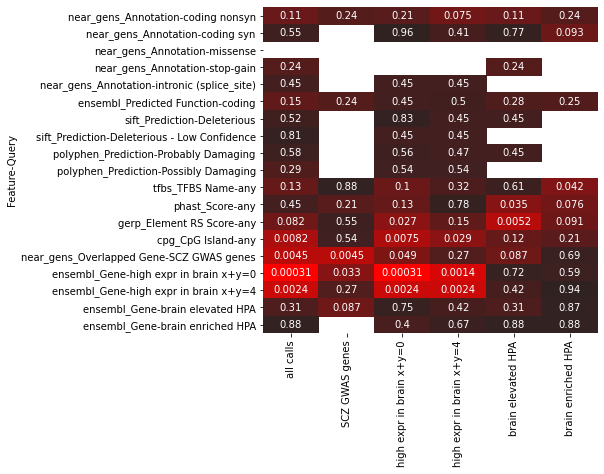

In [25]:
%matplotlib inline
cm = sns.dark_palette('red', as_cmap=True)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(chisq_stat, annot=chisq_p, ax=ax, cmap=cm, cbar=False)
attila_utils.savefig(fig, 'chisq-heatmap')

### Sample mean and standard error 

Calls per individuals: sample mean and standard error of mean

In [26]:
callsperind = operations.summarize_query_mean_sem(results, data)

['named-figure/norm-counts-per-indiv-barplot.png',
 'named-figure/norm-counts-per-indiv-barplot.pdf']

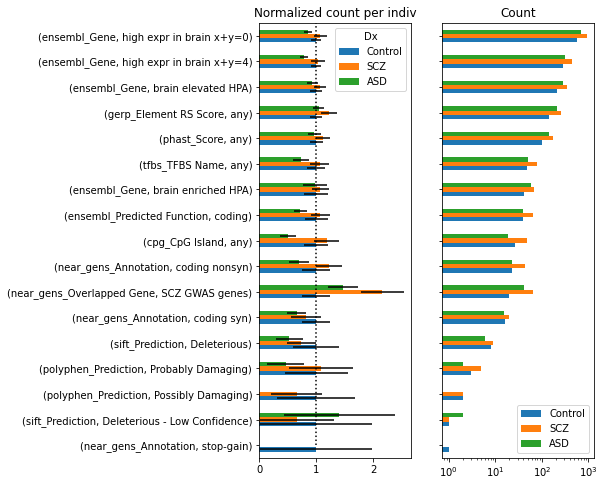

In [27]:
stdcpi = callsperind.sort_values(('Control', 'mean'), ascending=True).apply(lambda x: x / x[('Control', 'mean')], axis=1).dropna()
%matplotlib inline
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6, 8))
ax[0].plot([1, 1], [0, 100], color='black', linestyle='dotted')
stdcpi.xs('mean', level=1, axis=1).plot(kind='barh', xerr=stdcpi.xs('sem', level=1, axis=1), ax=ax[0])
ax[0].set_title('Normalized count per indiv')
summary.loc[stdcpi.index, ['Control', 'SCZ', 'ASD']].plot(kind='barh', ax=ax[1], logx=True, stacked=False)
ax[1].set_title('Count')
attila_utils.savefig(fig, 'norm-counts-per-indiv-barplot')

### Figure illustrating enrichment in Schizophrenia GWAS genes

In [28]:
def get_genomewide_rate(aggfun):
    d = {Dx: aggfun(results.loc[results.Dx == Dx].groupby('Individual ID').size()) for Dx in results.Dx.cat.categories}
    #df = pd.DataFrame(d)
    return(d)

genomewide_rate = pd.DataFrame({'mean': get_genomewide_rate(np.mean), 'sem': get_genomewide_rate(scipy.stats.sem)})
genomewide_rate

,mean,sem
Control,41.325000,3.437797
SCZ,40.786885,3.989406
ASD,40.087719,3.090153


In [29]:
scz_gwas_genes_rate = pd.DataFrame({stat: callsperind.xs('SCZ GWAS genes', 0, 1).xs(stat, 1, 1).to_numpy()[0] for stat in ['mean', 'sem']}, index=results.Dx.cat.categories)
scz_gwas_genes_rate

,mean,sem
Control,0.500000,0.122474
SCZ,1.081967,0.191593
ASD,0.736842,0.134817


['named-figure/genomewide-scz_gwas-rate.png',
 'named-figure/genomewide-scz_gwas-rate.pdf']

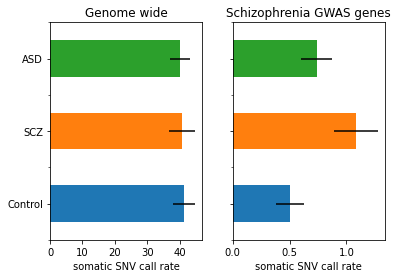

In [33]:
def my_barh(df, ax):
    df['mean'].plot(kind='barh', xerr=df['sem'], ax=ax, color=['C0', 'C1', 'C2'])
    ax.set_xlabel('somatic SNV call rate')
    return(ax)

def my_2barh(lastDx):
    fig, ax = plt.subplots(1, 2, sharey=True)
    my_barh(genomewide_rate[:lastDx], ax[0])
    my_barh(scz_gwas_genes_rate[:lastDx], ax[1])
    ax[0].set_title('Genome wide')
    ax[1].set_title('Schizophrenia GWAS genes')
    return((fig, ax))
    
fig, ax = my_2barh('ASD')
attila_utils.savefig(fig, 'genomewide-scz_gwas-rate')

Now without ASD individuals

['named-figure/genomewide-scz_gwas-rate_scz.png',
 'named-figure/genomewide-scz_gwas-rate_scz.pdf']

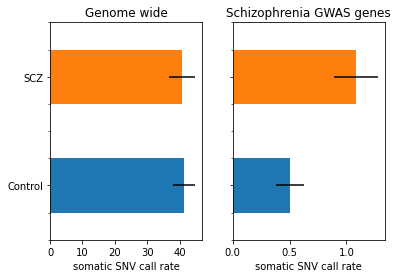

In [34]:
fig, ax = my_2barh('SCZ')
attila_utils.savefig(fig, 'genomewide-scz_gwas-rate_scz')

## TODO

Use Taejeong's definition of functional variants

> The terms that we chose as functional are missense, stop_gained, splice_region, regulatory, and TF_binding.

In [32]:
%connect_info

{
  "shell_port": 59659,
  "iopub_port": 50945,
  "stdin_port": 45879,
  "control_port": 35943,
  "hb_port": 34559,
  "ip": "127.0.0.1",
  "key": "3490718c-1f8cdfd85e0542d4d47173ce",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-fbd35f60-f2b8-4266-af86-22af1dd8a2fe.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
